In [1]:
import torch
from trak import TRAKer
from tqdm.auto import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from diffusion_trak import DiffusionModelOutput
from diffusion_trak import DiffusionGradientComputer
from diffusers import DDPMScheduler
from datasets import load_dataset_builder
from datasets import load_dataset
from numpy.lib.format import open_memmap
import numpy as np

# local import
from utils import get_cifar_model, get_cifar_loader
from demo_utils import load_checkpoints, load_trak_results

# CIFAR-10 unconditional model

In [2]:
model = get_cifar_model(sample_size=32, n_channels=3)
model.eval();

In [3]:
checkpoints = load_checkpoints('CIFAR10', root='.')
model.load_state_dict(checkpoints[0])

Models already downloaded and extracted.


<All keys matched successfully>

In [4]:
loader_train = get_cifar_loader(batch_size=32, split='train')

## Generate sample trajectories with DDPM

We'll now generate some samples $x_0$ by running the DDPM sampler for a thousand iterations, starting from $x_{1000}$ and iteratively denoising the batch of latent images.

In [5]:
N = 20
# fixing the seed for reproducibility
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# drawing the random sample x_1000
input = torch.randn((N, 3, 32, 32)).to("cuda")
noise_scheduler = DDPMScheduler()

trajectory = []

for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    d = noise_scheduler.step(noisy_residual, t, input)
    previous_noisy_sample = d.prev_sample
    x_0_hat = d.pred_original_sample
    input = previous_noisy_sample
    trajectory.append(x_0_hat.detach().clone().cpu())

# flip the order so trajectory[0] gives us the final image
trajectory = torch.stack(trajectory[::-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

### The synthesized images

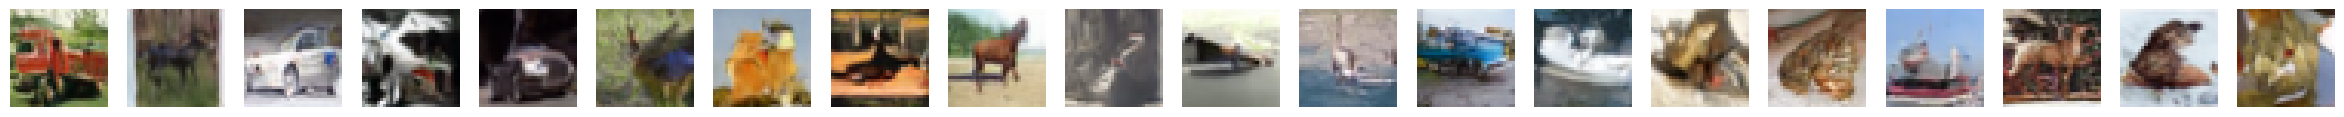

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(1.5 * N, 1.5))
for ii in range(N):
    axs[ii].imshow((trajectory[0, ii].permute([1, 2, 0]) + 1) / 2)
    axs[ii].axis('off')
plt.show()

This is effectively the same as running the `DDPMPipeline`. We do the above in order to get access to the full trajectory of intermediate latents $x_t$, in addition to the batch of final images $x_0$.

## Attribute the sample trajectory at a timestep of choice

In [7]:
load_trak_results('CIFAR10', root='.')

Models already downloaded and extracted.


In [ ]:
task = DiffusionModelOutput()

traker = TRAKer(model=model,
                task=task,
                gradient_computer=DiffusionGradientComputer,
                proj_dim=2048,
                train_set_size=len(loader_train.dataset),
                save_dir='./CIFAR10_trak_results',
                device='cuda')

Here we choose to set the timesteps $t=100$ and $t=300$. Thus, we feed the latents $x_{100}$ and $x_{300}$, respectively, to our `TRAKer` instance.

We also provide pre-computed scores for $t=300$, so feel free to skip the remaining cells until the "Analyze scores" section

In [14]:
scores = {
    300: np.array(open_memmap('./CIFAR10_trak_results/scores/DEMO_T=300.mmap'))
}

In [10]:
scores = {}  # dictionary {timestep: scores_for_that_timestep}

In [ ]:
exp_name = "DEMO_T=100"
num_resamplings = 20

timestep = torch.tensor(100)

bs = trajectory.shape[1]

for model_id in tqdm(range(len(checkpoints))):
    ckpt = checkpoints[model_id]
    traker.start_scoring_checkpoint(exp_name=exp_name, checkpoint=ckpt, model_id=model_id, num_targets=bs)

    # images, labels, tstep, n_iters
    batch = [trajectory.permute([1, 0, 2, 3, 4]).half(), torch.zeros(bs), timestep, num_resamplings]
    traker.score(batch=batch, num_samples=bs)

scores[100] = traker.finalize_scores(exp_name=exp_name, allow_skip=True)

In [ ]:
exp_name = "DEMO_T=300"
num_resamplings = 20

timestep = torch.tensor(300)

bs = trajectory.shape[1]

for model_id in tqdm(range(len(checkpoints))):
    ckpt = checkpoints[model_id]
    traker.start_scoring_checkpoint(exp_name=exp_name, checkpoint=ckpt, model_id=model_id, num_targets=bs)

    # images, labels, tstep, n_iters
    batch = [trajectory.permute([1, 0, 2, 3, 4]).half(), torch.zeros(bs), timestep, num_resamplings]
    traker.score(batch=batch, num_samples=bs)

scores[300] = traker.finalize_scores(exp_name=exp_name, allow_skip=True)

# Analyze scores

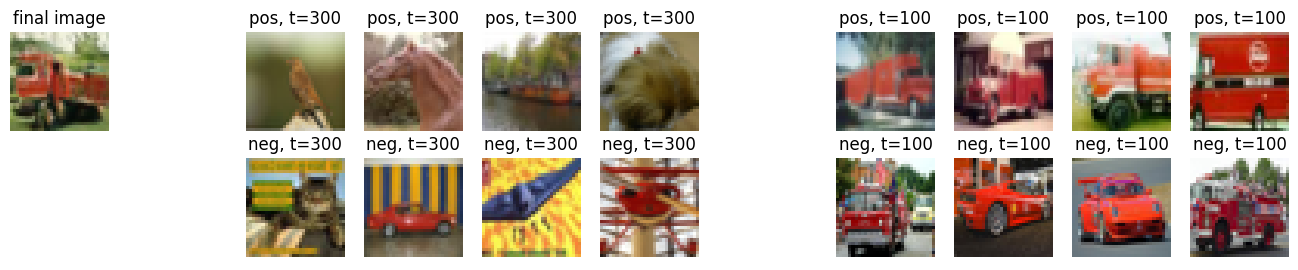

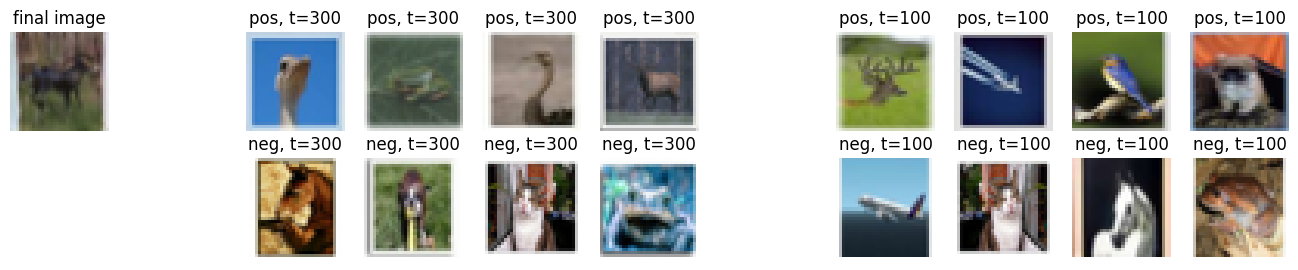

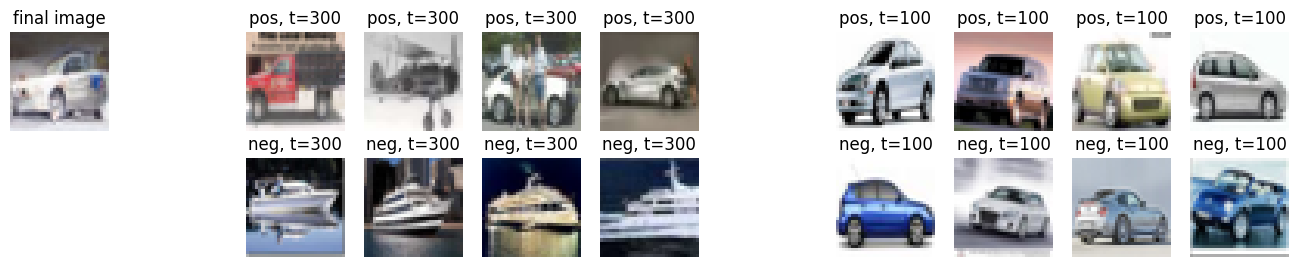

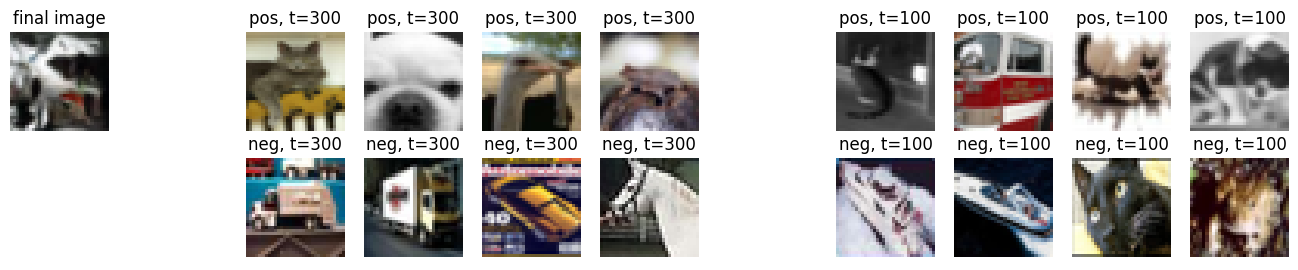

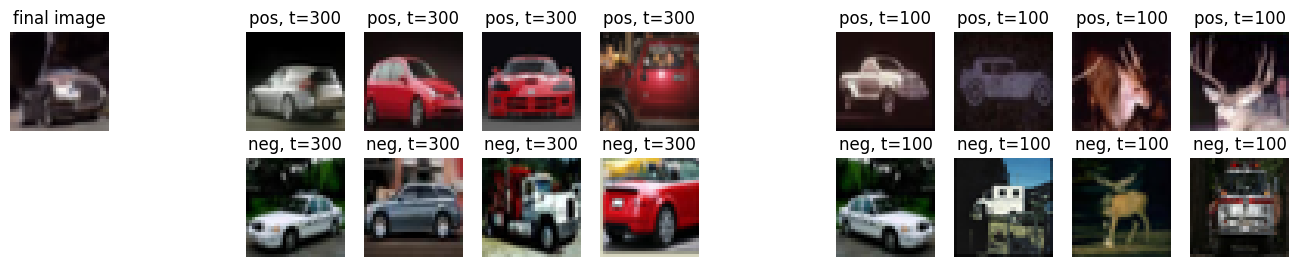

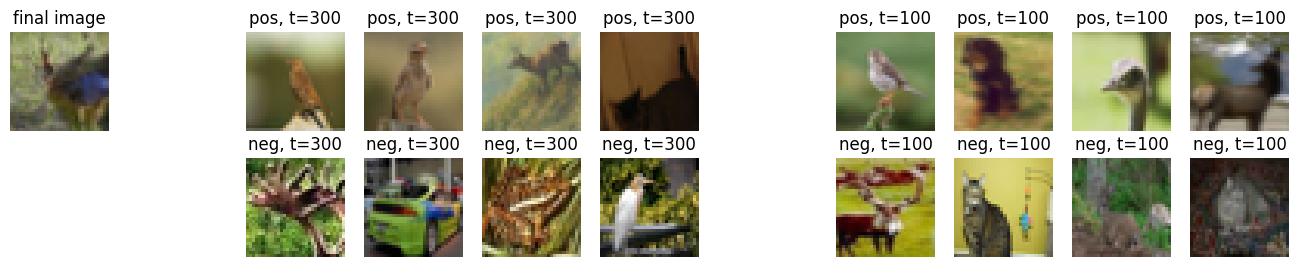

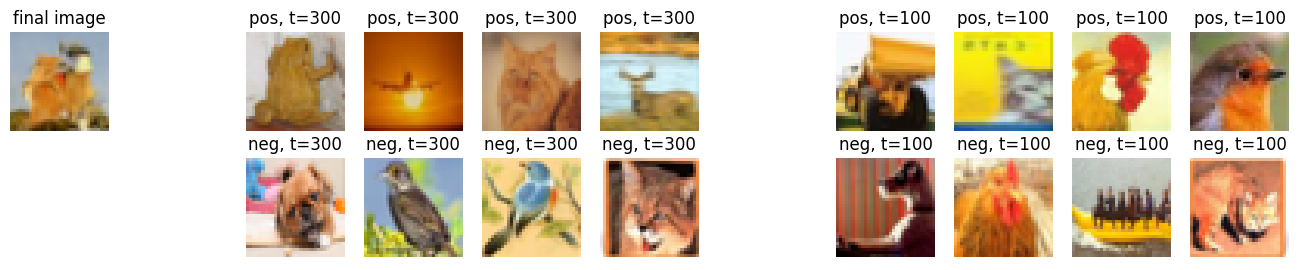

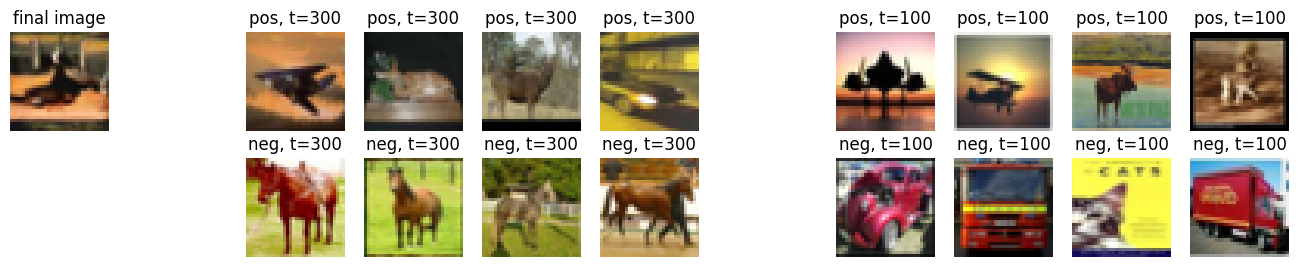

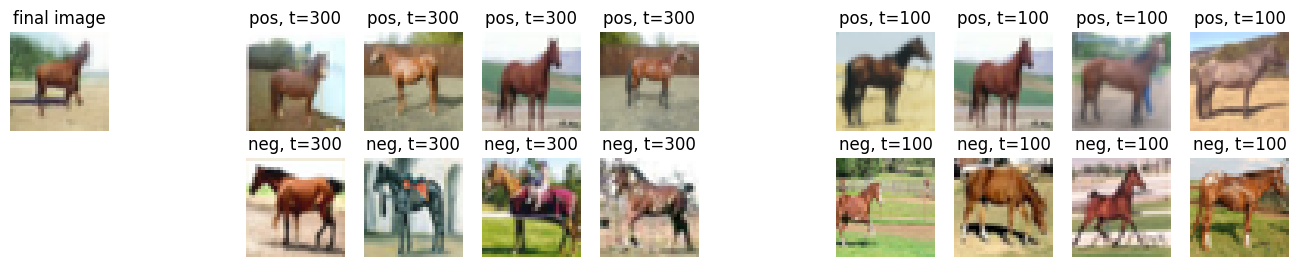

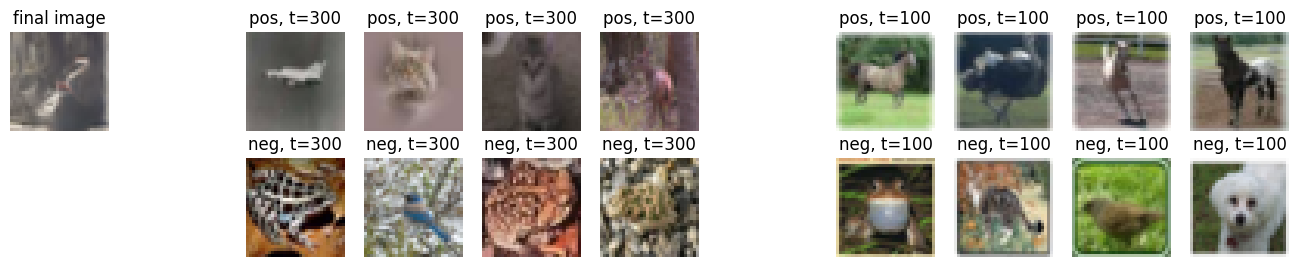

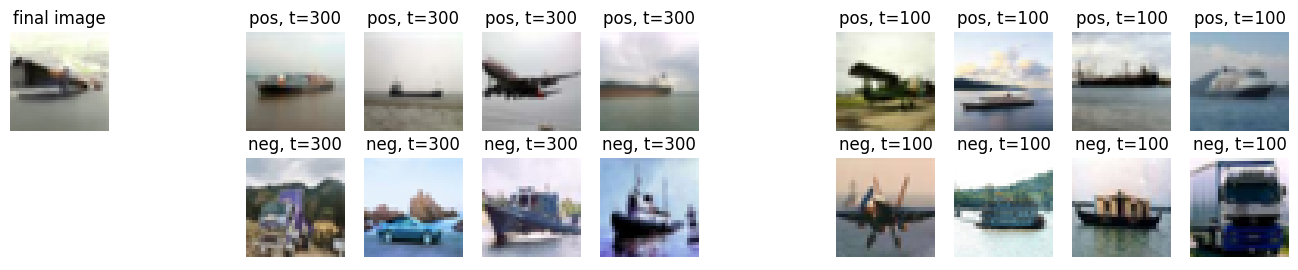

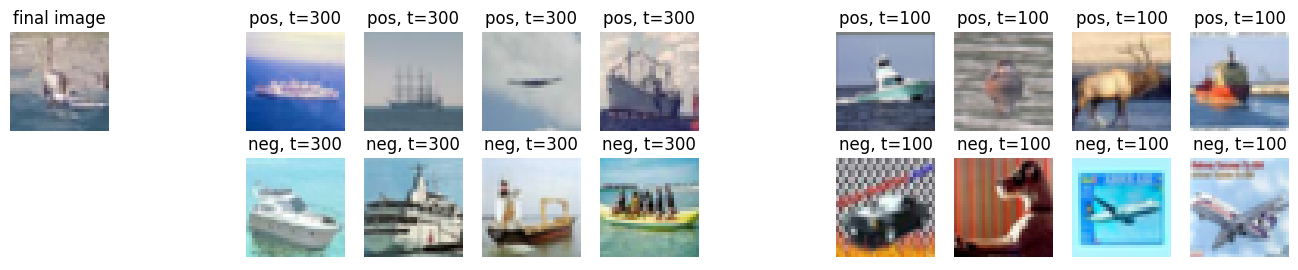

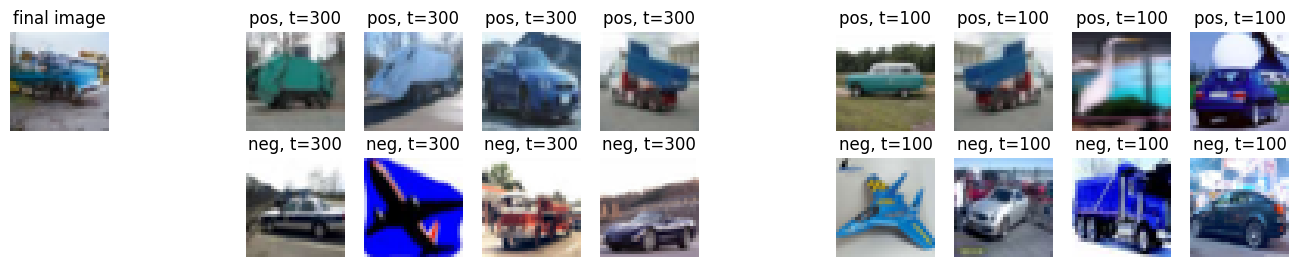

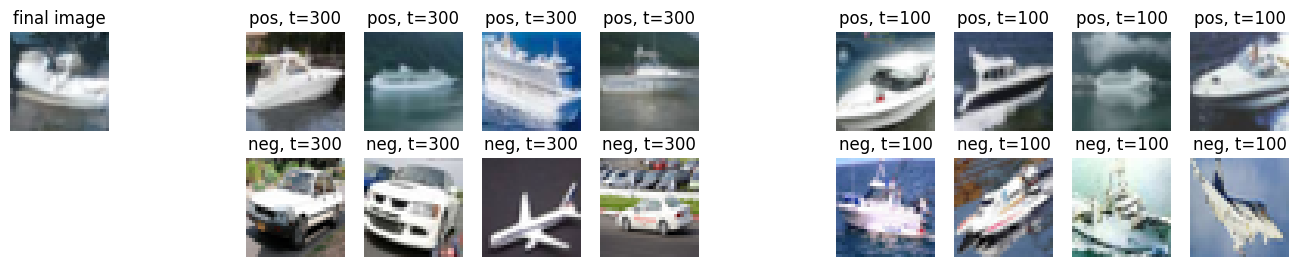

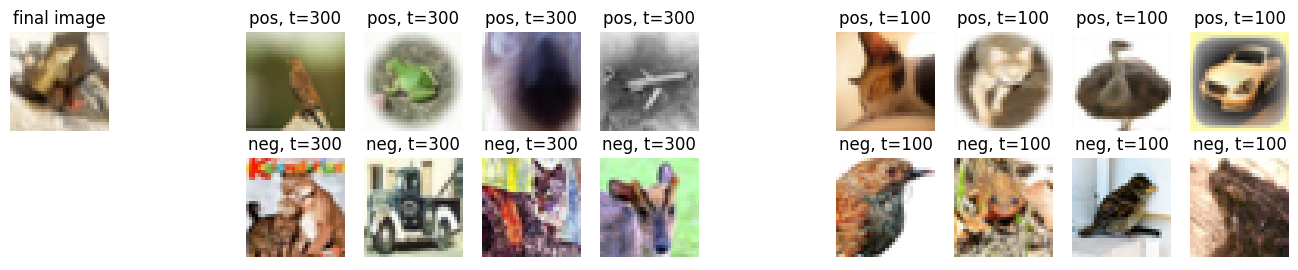

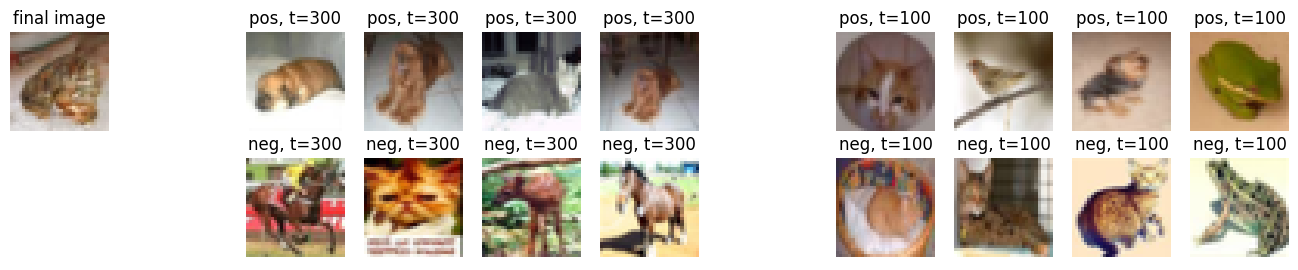

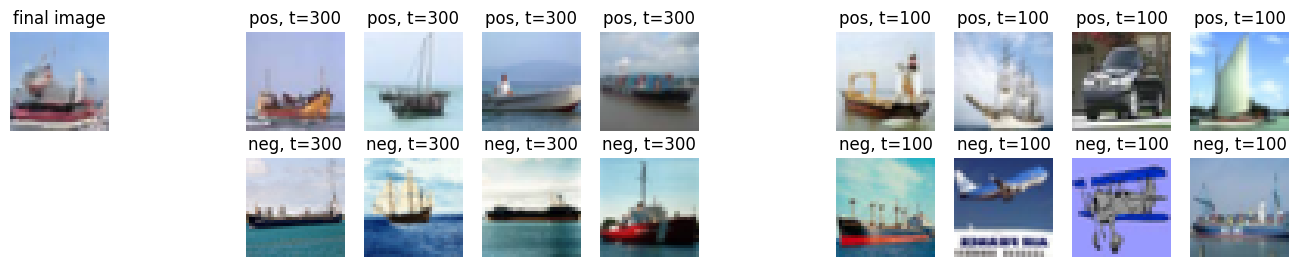

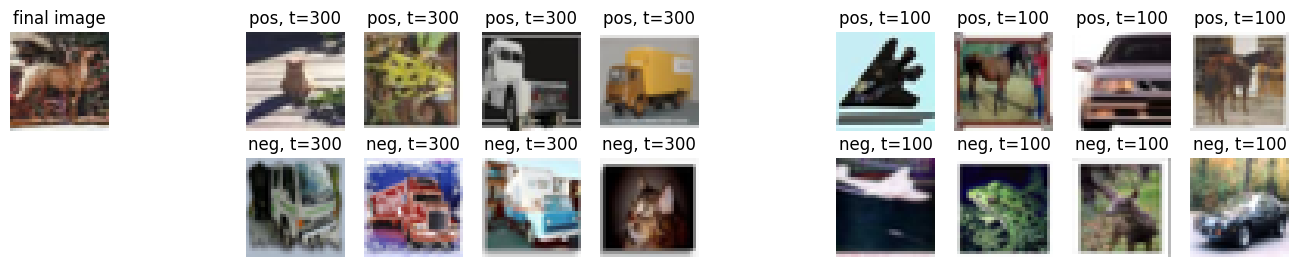

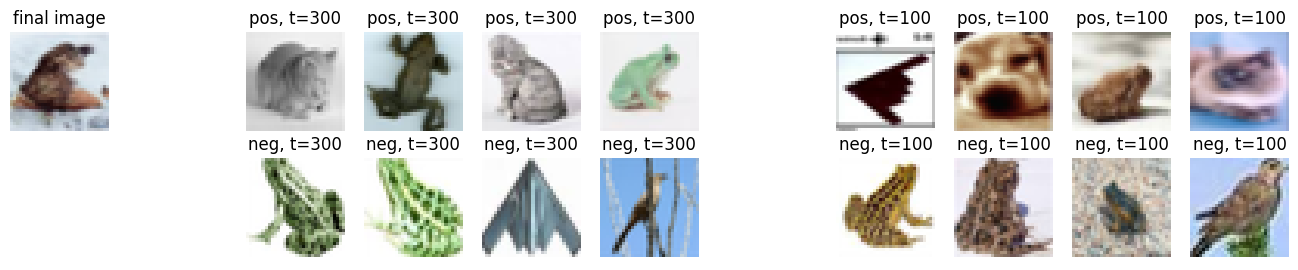

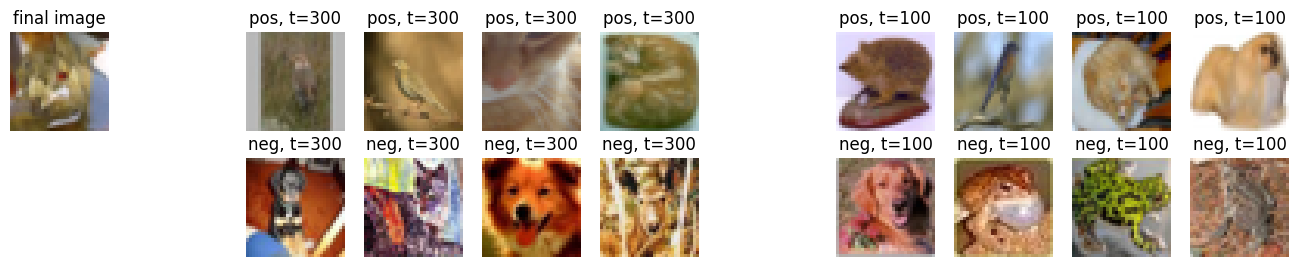

In [18]:
k = 4 # visualize the k training examples with most positive/negative TRAK scores
T = len(list(scores.keys()))
for i in range(N):
    top_inds = {}
    bot_inds = {}
    for t in scores.keys():
        top_inds[t] = torch.tensor(scores[t][:, i]).reshape(-1).argsort()[-k:].flip(dims=[0])
        bot_inds[t] = torch.tensor(scores[t][:, i]).reshape(-1).argsort()[:k]
    
    fig, axs = plt.subplots(nrows=2, ncols=T * k + 3, figsize=(1.5 * (T * k + T + 1), 3))
    for ax in axs.ravel():
        ax.set_axis_off()

    axs[0, 0].imshow((trajectory[0, i].permute([1, 2, 0]) + 1) / 2)
    axs[0, 0].set_title('final image')
    
    for it, t in enumerate(scores.keys()):
        for ii in range(k):
            axs[0, ii + it * (k + 1) + 2].imshow((loader_train.dataset[top_inds[t][ii].item()]['images'].permute([1, 2, 0]) + 1) / 2)
            axs[0, ii + it * (k + 1) + 2].set_title(f'pos, t={t}')
            axs[1, ii + it * (k + 1) + 2].imshow((loader_train.dataset[bot_inds[t][ii].item()]['images'].permute([1, 2, 0]) + 1) / 2)
            axs[1, ii + it * (k + 1) + 2].set_title(f'neg, t={t}')
plt.show()